<a href="https://colab.research.google.com/github/matteoturnu/NetSecProject/blob/main/NetSec_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Studio di correlazione e distribuzione sulle features

Importazione dataset

In [1]:
import pandas as pd

url = 'https://raw.githubusercontent.com/matteoturnu/NetSecProject/refs/heads/main/BenignAndMaliciousDataset.csv'
traffic_df = pd.read_csv(url)

print(traffic_df.shape)


(90000, 34)


Test di ANOVA per vedere quanto le feature sono significative

In [2]:
from scipy import stats

numeric_dataset = traffic_df.select_dtypes(include=['number','boolean'])
# we removed domain because they are based on incremental IDs
new_numeric_dataset = numeric_dataset.drop(columns=['Domain'])

# Supponiamo che la colonna 'target' contenga 0 per traffico benevolo e 1 per traffico malevolo
target = 'Class'
feature_columns = [col for col in new_numeric_dataset.columns if col != target]

# Test ANOVA per ciascuna feature numerica
p_values = {}  # Dizionario per salvare i p-values
for feature in feature_columns:
    # Dividi i dati in due gruppi (malevolo e benevolo)
    group_benign = new_numeric_dataset[new_numeric_dataset[target] == 0][feature]
    group_malicious = new_numeric_dataset[new_numeric_dataset[target] == 1][feature]
    # Applica ANOVA
    stat, p_value = stats.f_oneway(group_benign, group_malicious)
    # Salva il p-value per ogni feature
    p_values[feature] = p_value
    # Verifica il risultato
    print(f'Feature: {feature}, P-value: {p_value}')
    if p_value < 0.01:  # Soglia di significatività 0.05
        print(f'La feature {feature} è significativa.')
    else:
        print(f'La feature {feature} NON è significativa.')

Feature: MXDnsResponse, P-value: 0.0
La feature MXDnsResponse è significativa.
Feature: TXTDnsResponse, P-value: 0.0
La feature TXTDnsResponse è significativa.
Feature: HasSPFInfo, P-value: 0.0
La feature HasSPFInfo è significativa.
Feature: HasDkimInfo, P-value: 0.0006456116132352973
La feature HasDkimInfo è significativa.
Feature: HasDmarcInfo, P-value: 1.3907683401786138e-62
La feature HasDmarcInfo è significativa.
Feature: Ip, P-value: 3.4211602974075064e-34
La feature Ip è significativa.
Feature: DomainInAlexaDB, P-value: 3.065702243016074e-94
La feature DomainInAlexaDB è significativa.
Feature: CommonPorts, P-value: 0.0
La feature CommonPorts è significativa.
Feature: CreationDate, P-value: 0.0
La feature CreationDate è significativa.
Feature: LastUpdateDate, P-value: 0.0
La feature LastUpdateDate è significativa.
Feature: ASN, P-value: 5.493047646465009e-109
La feature ASN è significativa.
Feature: HttpResponseCode, P-value: 0.0
La feature HttpResponseCode è significativa.
Featu

Previous test shows these features are not important for determining the class

In [3]:
new_numeric_dataset = new_numeric_dataset.drop(columns=['DomainReputation', 'SubdomainNumber'])

Distribuzione tra benevolo e malevolo tra le features

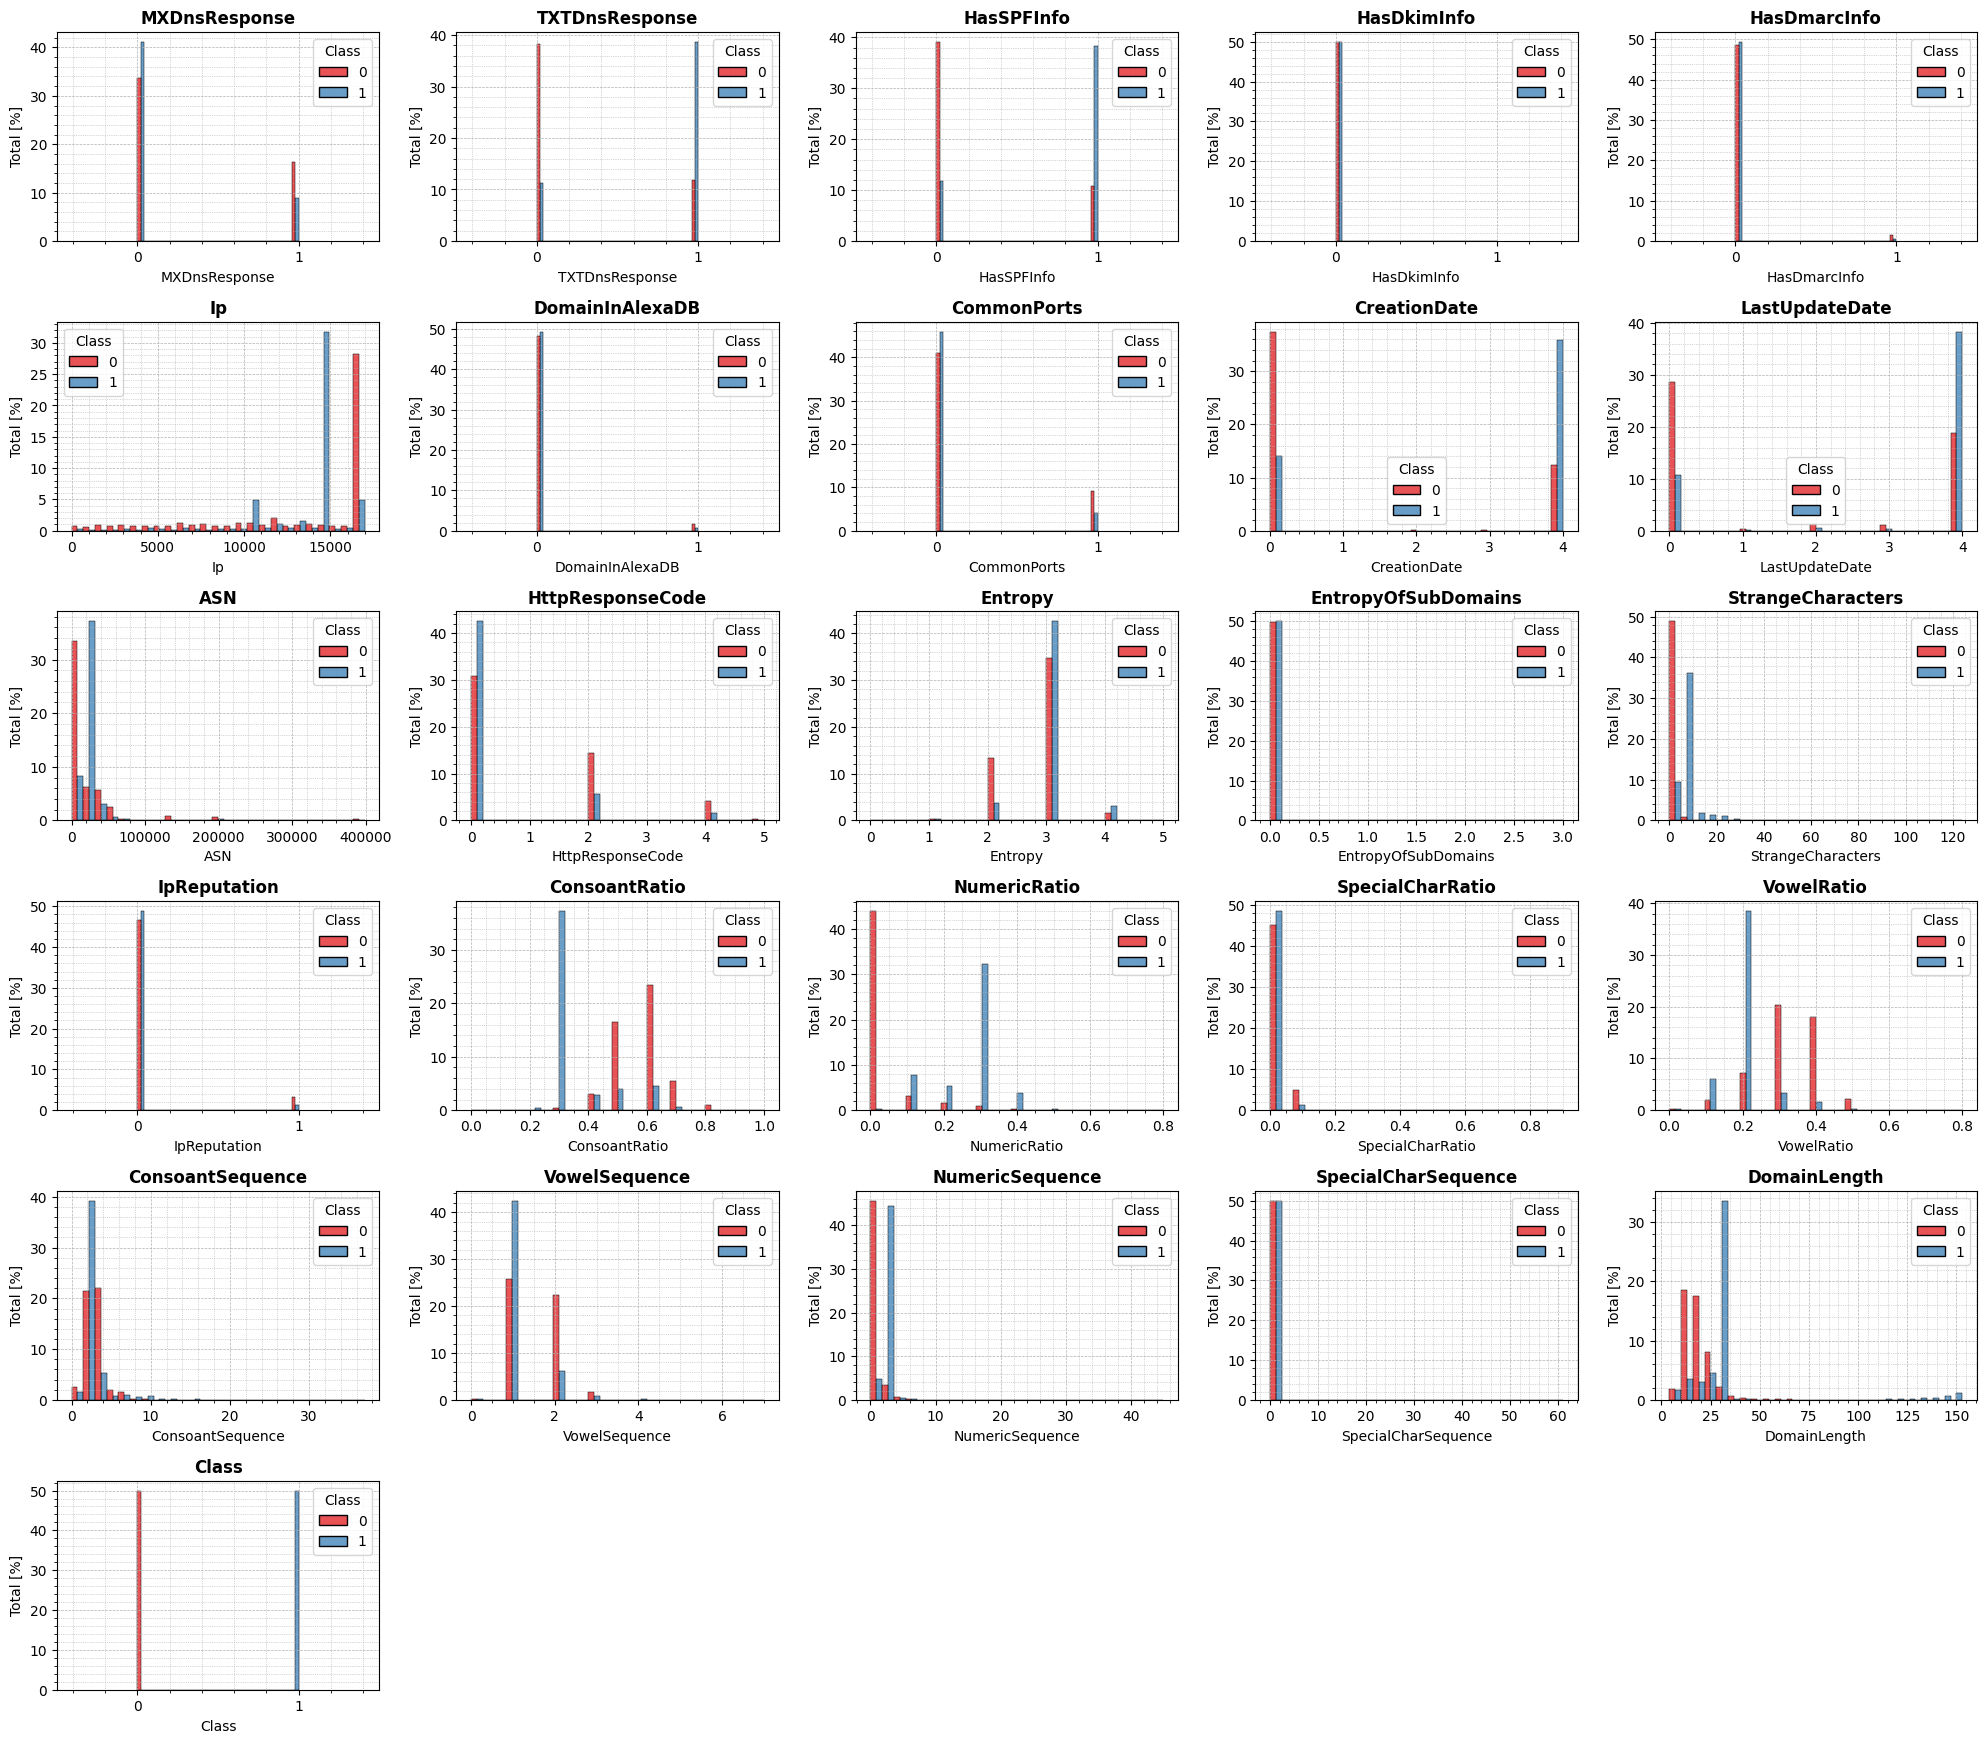

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crea una figura con sottotrame per ciascuna feature
plt.figure(figsize=(20, 20))

# Cicla attraverso le feature finali
for i, feature in enumerate(new_numeric_dataset, 1):
    plt.subplot(7, 5, i)
    plot = sns.histplot(data=traffic_df, x=feature, hue='Class', multiple='dodge', palette='Set1', bins=25, stat='percent')

    if traffic_df[feature].nunique() == 2:  # Controlla se la feature ha solo 2 valori (booleano)
        plt.xticks([0, 1])
        plt.xlim(-0.5, 1.5)

    plt.title(f'{feature}', fontweight='bold')
    plt.ylabel('Total [%]')

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', linewidth=0.5)

# Mostra la figura
plt.tight_layout()
plt.show()

I grafici mostrano come alcune features sia equamente distribuite tra campioni malevoli e benevoli

In [5]:
new_numeric_dataset = new_numeric_dataset.drop(columns=['HasDkimInfo', 'HasDmarcInfo', 'DomainInAlexaDB', 'CommonPorts', 'EntropyOfSubDomains', 'IpReputation'])

Studio di correlazione

<Axes: >

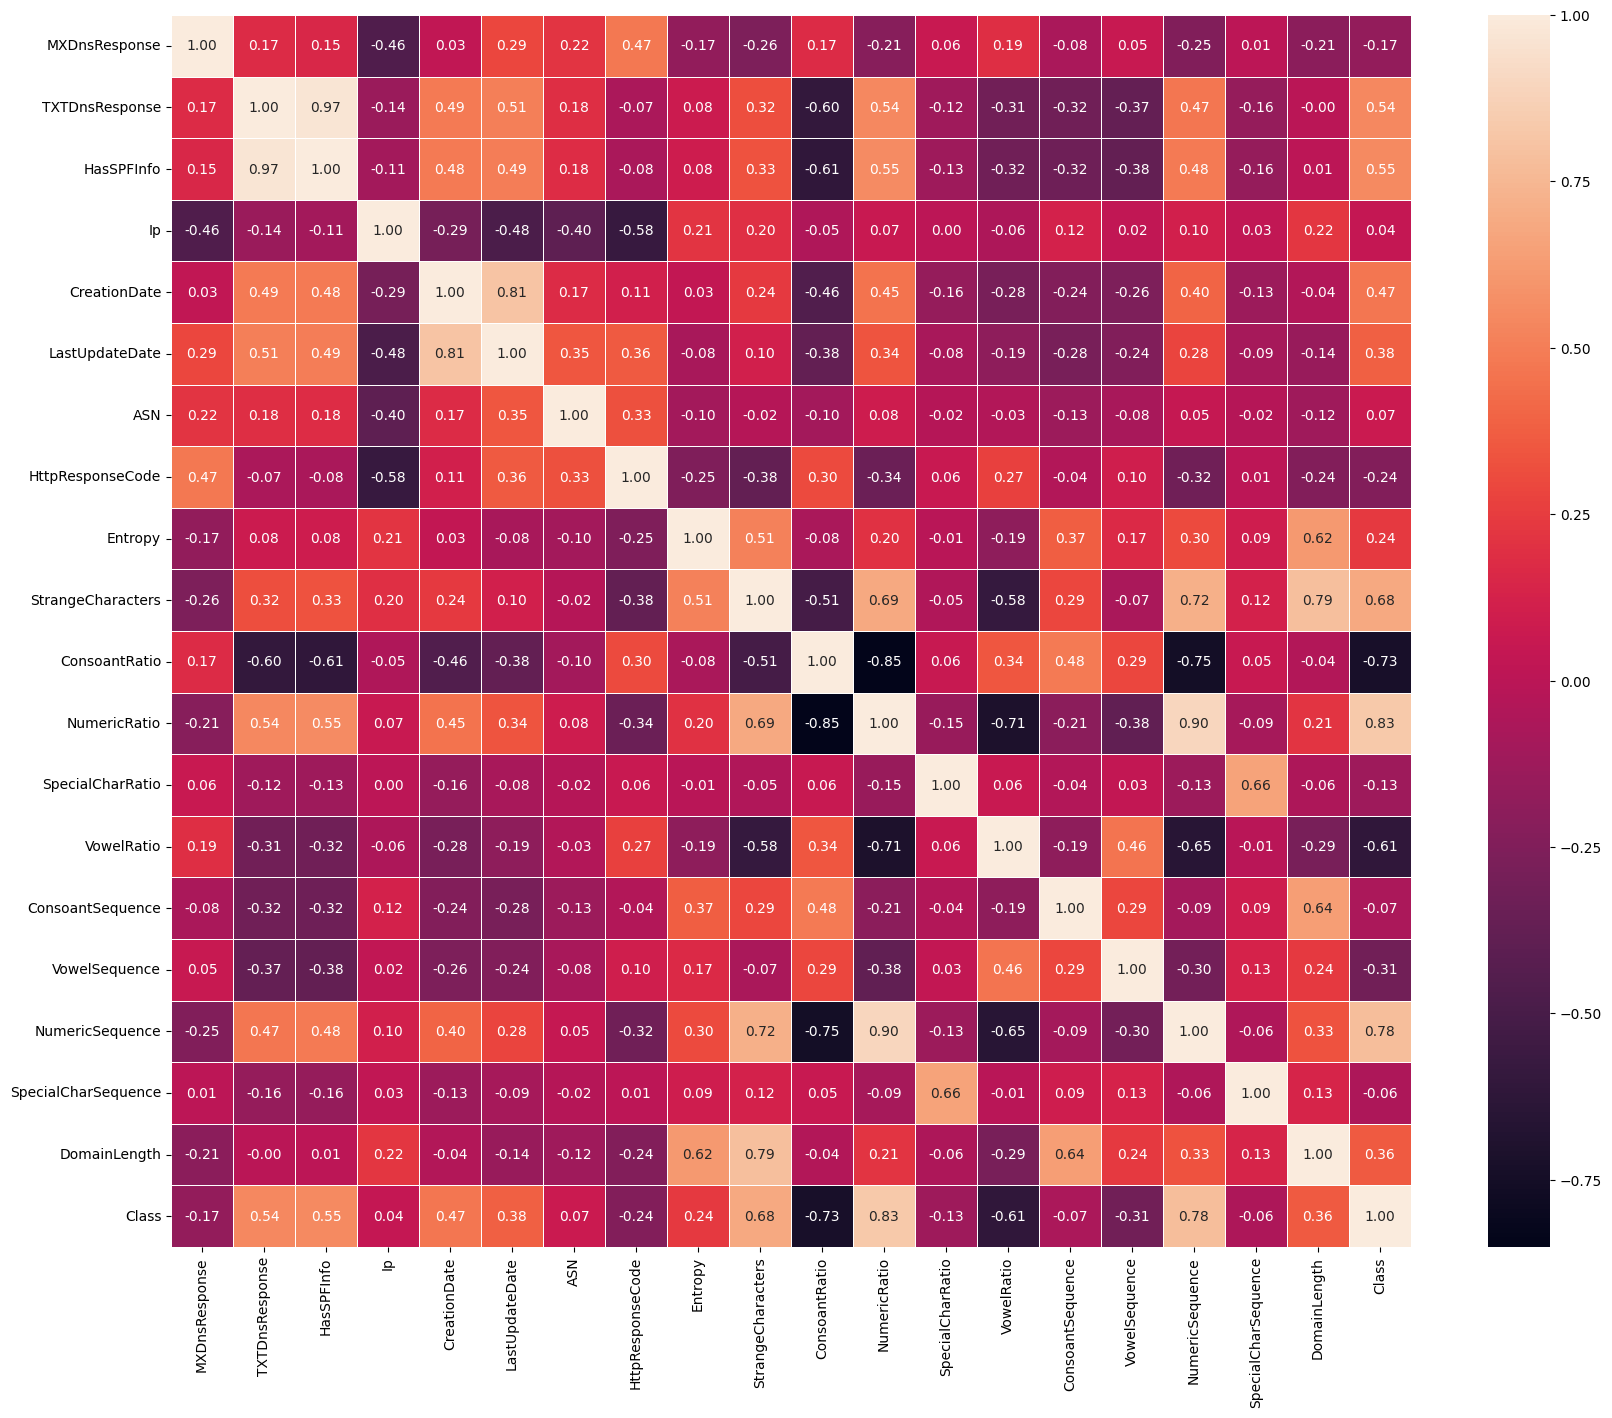

In [6]:
corr_matrix = new_numeric_dataset.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, linewidth=0.5, fmt='.2f')

Chosen features (based on high correlation with the class)
- TXTDnsResponse
- HasSPFInfo
- StrangeCharacters
- ConsonantRatio
- Numeric ratio
- VowelRatio
- NumericSequence

<Axes: >

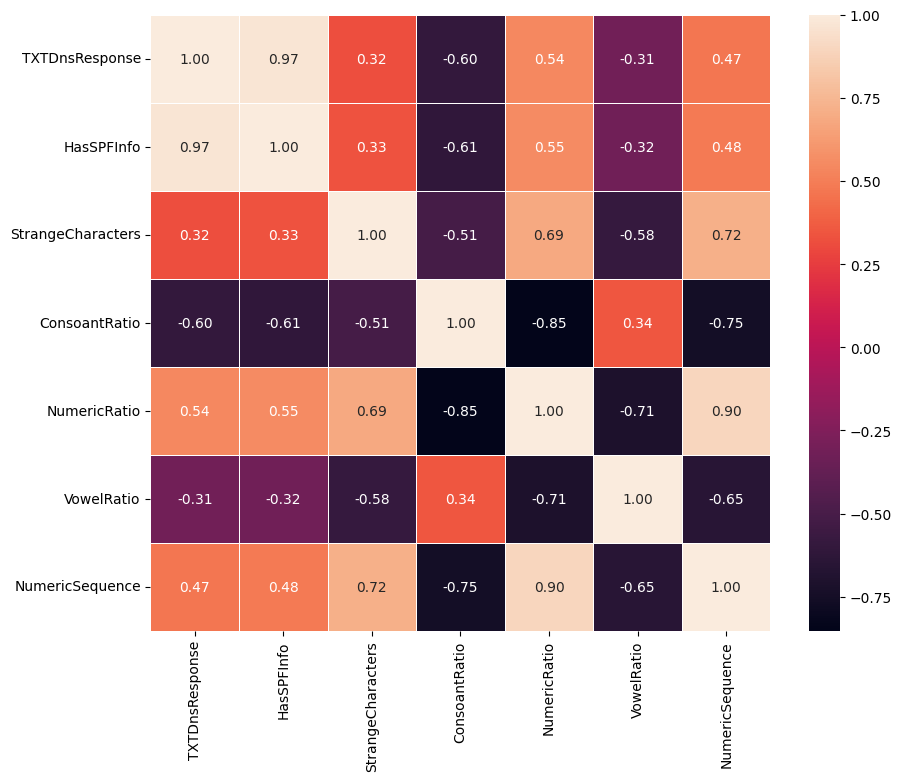

In [7]:
features = ['TXTDnsResponse', 'HasSPFInfo', 'StrangeCharacters', 'ConsoantRatio', 'NumericRatio', 'VowelRatio', 'NumericSequence']
new_numeric_dataset = new_numeric_dataset[features]

corr_matrix = new_numeric_dataset.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, linewidth=0.5, fmt='.2f')

Now, looking at correlation between features themselves:
- choosing consonantRatio against NumericRatio
- keeping TXTDnsResponse against HasSPFInfo
- choosing NumericSequence against consonantRatio (4 features left)

Left: NumericSequence, TXTDnsResponse, StrangeCharacters, VowelRatio (next test: maybe remove NumericSequence or VowelRatio)

In [8]:
final_features = ['TXTDnsResponse', 'StrangeCharacters', 'VowelRatio', 'NumericSequence']

## Test to evaluate how much the samples distribution is a Gaussian one

In [9]:
study_features=['TXTDnsResponse', 'StrangeCharacters', 'VowelRatio', 'NumericSequence', 'Class']
dataset_study=traffic_df[study_features]
dataset_ben= dataset_study[dataset_study['Class']==1]
dataset_mal= dataset_study[dataset_study['Class']==0]

# Esegui il test di Shapiro-Wilk
stat, p_value = stats.shapiro(dataset_ben)

print('Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('Distribuzione probabilmente normale (non rifiuto H0)')
else:
    print('Distribuzione non normale (rifiuto H0)')

stat, p_value = stats.shapiro(dataset_mal)

print('Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('Distribuzione probabilmente normale (non rifiuto H0)')
else:
    print('Distribuzione non normale (rifiuto H0)')

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 225000.
  res = hypotest_fun_out(*samples, **kwds)


Statistic: 0.6557978084271938
p-value: 1.0974990318937638e-168
Distribuzione non normale (rifiuto H0)
Statistic: 0.27542616677874854
p-value: 5.985520266058562e-195
Distribuzione non normale (rifiuto H0)


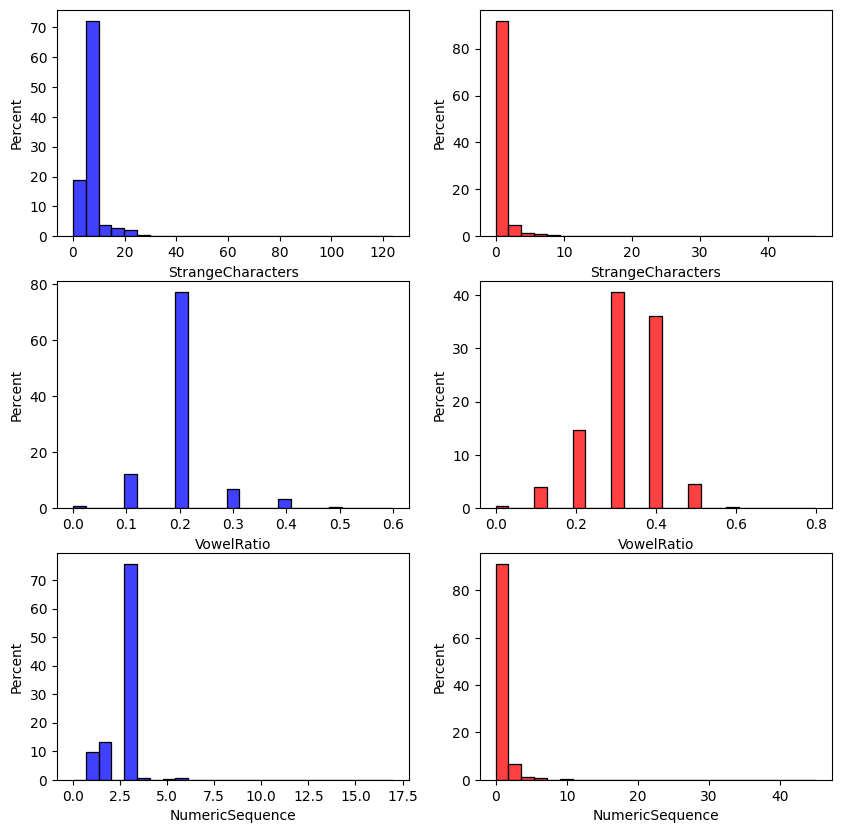

In [22]:
import numpy as np

plt.figure(figsize=(10, 10))

i = 1
for feature in final_features[1:]:
  for j in range(2):
    plt.subplot(3, 2, i)
    if i % 2 == 1:
      plot = sns.histplot(data=dataset_ben, x=feature, multiple='dodge', bins=25, stat='percent', color='blue')
    else:
      plot = sns.histplot(data=dataset_mal, x=feature, multiple='dodge', bins=25, stat='percent', color='red')
    i += 1

plt.show()

Sort of probability distribution for each feature. They are NO gaussian ones so it's not possible to suppose that data has Gaussian distribution

# KNN

K-NN con tutte le feature

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

# k values to try
k_values = [5, 10, 20, 50, 100, 200, 300]

X = traffic_df[final_features] # 4 features
y = traffic_df['Class']

# Split dataset into 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature normalization for KNN
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit the model
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Model evaluation
y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

TP = cm[1, 1]  # veri positivi
TN = cm[0, 0]  # veri negativi
FP = cm[0, 1]  # falsi positivi
FN = cm[1, 0]  # falsi negativi

TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
FNR = FN / (TP + FN) if (TP + FN) > 0 else 0

P = TP/(TP+FP)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(f'True Positive Ratio: {TPR:.2f}')
print(f'False Negative Ratio: {FNR:.2f}')
print(f'Precision: {P:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

# Test on accuracy for different values of k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    print(f'k={k}, Accuracy: {accuracy_score(y_test, y_pred):.2f}')


KeyboardInterrupt: 

K-NN sulle features prese singolarmente

In [ ]:
for feature in X:
  print(f"\nAnalizzando la feature: {feature}")

  feature_vector = traffic_df[feature].values.reshape(-1, 1)  # Reshape per ottenere una 2D array

  X_train, X_test, y_train, y_test = train_test_split(feature_vector, y, test_size=0.3, random_state=42)

  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  k = 5
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)

  y_pred = knn.predict(X_test)

  print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
  print('Classification Report:')
  print(classification_report(y_test, y_pred))

  for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print(f'k={k}, Accuracy: {accuracy_score(y_test, y_pred):.2f}')